<a href="https://colab.research.google.com/github/HowardAlvarez08/ai-environmental-risk-predictor/blob/main/AI_Prediction_(Plan_C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Season 1: Historical Dataset ML Training

STEP 1 — Setup & Install Dependencies (RUN THIS FIRST)

In [ ]:
# STEP 1 — Setup & Install Dependencies (RUN THIS FIRST)

!pip install openmeteo-requests requests-cache retry-requests

In [ ]:
# For compatibility

!pip install -q urllib3==1.26.18 requests-cache retry-requests openmeteo-requests

🟩 STEP 2 — Import Libraries (Cell 2)

In [ ]:
# Import Libraries

import openmeteo_requests
import requests_cache
from retry_requests import retry

import pandas as pd
import numpy as np


🟩 STEP 3 — Fetch HISTORICAL DAILY DATA (Cell 3)

In [ ]:
import pandas as pd
import requests_cache, calendar
from retry_requests import retry
import openmeteo_requests

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession(".cache", expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.5)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Use ERA5 reanalysis endpoint
url = "https://archive-api.open-meteo.com/v1/era5"

years = range(2018, 2024)   # 2018–2023
months = range(1, 13)       # All months

all_hourly_frames = []

variables = [
    "temperature_2m",
    "relative_humidity_2m",
    "dew_point_2m",
    "precipitation",
    # "rain", # Removed as ERA5 does not provide 'rain'
    "soil_moisture_0_to_1cm",
    "soil_moisture_1_to_3cm",
    "soil_moisture_3_to_9cm",
    "soil_moisture_9_to_27cm",
    "soil_moisture_27_to_81cm",
    "soil_temperature_0cm",
    "soil_temperature_6cm",
    "soil_temperature_18cm",
    "soil_temperature_54cm",
    "wind_speed_10m",
    "wind_direction_10m",
    "wind_gusts_10m",
    "pressure_msl",
    "cloud_cover",
    "visibility",
    "cape",
    "lifted_index"
    # "convective_inhibition" # Removed as ERA5 does not provide 'convective_inhibition'
]

for year in years:
    for month in months:
        start_date = f"{year}-{month:02d}-01"
        end_date = f"{year}-{month:02d}-{calendar.monthrange(year, month)[1]}"
        print(f"Fetching {year}-{month:02d}...")

        params = {
            "latitude": 14.5995,
            "longitude": 120.9842,
            "start_date": start_date,
            "end_date": end_date,
            "hourly": variables,
            "timezone": "Asia/Singapore"
        }

        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]
        hourly = response.Hourly()

        hourly_data = {
            "date": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left"
            )
        }

        # Map variables dynamically
        for i, var in enumerate(variables):
            hourly_data[var] = hourly.Variables(i).ValuesAsNumpy()

        df_month = pd.DataFrame(hourly_data)

        # Convert UTC → Philippine time
        df_month["date"] = (
            df_month["date"]
            .dt.tz_convert("Asia/Manila")
            .dt.tz_localize(None)
        )

        all_hourly_frames.append(df_month)

# Combine all months/years
hourly_dataframe = pd.concat(all_hourly_frames, ignore_index=True)

print("\nFinal Hourly Data Shape:", hourly_dataframe.shape)
print(hourly_dataframe.head())

Fetching 2018-01...
Fetching 2018-02...
Fetching 2018-03...
Fetching 2018-04...
Fetching 2018-05...
Fetching 2018-06...
Fetching 2018-07...
Fetching 2018-08...
Fetching 2018-09...
Fetching 2018-10...
Fetching 2018-11...
Fetching 2018-12...
Fetching 2019-01...
Fetching 2019-02...
Fetching 2019-03...
Fetching 2019-04...
Fetching 2019-05...
Fetching 2019-06...
Fetching 2019-07...
Fetching 2019-08...
Fetching 2019-09...
Fetching 2019-10...
Fetching 2019-11...
Fetching 2019-12...
Fetching 2020-01...
Fetching 2020-02...
Fetching 2020-03...
Fetching 2020-04...
Fetching 2020-05...
Fetching 2020-06...
Fetching 2020-07...
Fetching 2020-08...
Fetching 2020-09...
Fetching 2020-10...
Fetching 2020-11...
Fetching 2020-12...
Fetching 2021-01...
Fetching 2021-02...
Fetching 2021-03...
Fetching 2021-04...
Fetching 2021-05...
Fetching 2021-06...
Fetching 2021-07...
Fetching 2021-08...
Fetching 2021-09...
Fetching 2021-10...
Fetching 2021-11...
Fetching 2021-12...
Fetching 2022-01...
Fetching 2022-02...


STEP 4 — Convert to Pandas DataFrame (Cell 4)

In [ ]:
# ===============================
# STEP 4 — Prepare Hourly DataFrame
# ===============================

# Copy hourly data to working DF
df = hourly_dataframe.copy()

# Rename columns to match feature engineering / ML pipeline naming
df.rename(columns={
    "temperature_2m": "temperature_mean",
    "relative_humidity_2m": "relative_humidity_mean",
    "pressure_msl": "sea_level_pressure_mean",
    "soil_moisture_27_to_81cm": "soil_moisture_mean",
    "wind_speed_10m": "wind_speed_max",
    "wind_gusts_10m": "wind_gust_max",
    "precipitation": "precipitation_sum",
    # "rain": "rain_sum", # Removed as 'rain' is not available from ERA5
    "cloud_cover": "cloud_cover_total",
    "dew_point_2m": "dew_point_mean",
    "soil_moisture_0_to_1cm": "soil_moisture_top",
    "soil_moisture_1_to_3cm": "soil_moisture_1_3cm",
    "soil_moisture_3_to_9cm": "soil_moisture_3_9cm",
    "soil_moisture_9_to_27cm": "soil_moisture_9_27cm",
    "soil_temperature_0cm": "soil_temperature_top",
    "soil_temperature_6cm": "soil_temperature_6cm",
    "soil_temperature_18cm": "soil_temperature_18cm",
    "soil_temperature_54cm": "soil_temperature_54cm"
}, inplace=True)

# Optional: keep only the relevant columns for ML
df = df[[
    "temperature_mean",
    "relative_humidity_mean",
    "dew_point_mean",
    "precipitation_sum",
    # "rain_sum", # Removed as 'rain_sum' is not available
    "soil_moisture_mean",
    "soil_moisture_top",
    "soil_moisture_1_3cm",
    "soil_moisture_3_9cm",
    "soil_moisture_9_27cm",
    "soil_temperature_top",
    "soil_temperature_6cm",
    "soil_temperature_18cm",
    "soil_temperature_54cm",
    "wind_speed_max",
    "wind_gust_max",
    "sea_level_pressure_mean",
    "cloud_cover_total",
    "visibility",
    "cape",
    "lifted_index"
    # "convective_inhibition" # Removed as 'convective_inhibition' is not available
]]

# Quick check
df.head()

,temperature_mean,relative_humidity_mean,dew_point_mean,precipitation_sum,soil_moisture_mean,soil_moisture_top,soil_moisture_1_3cm,soil_moisture_3_9cm,soil_moisture_9_27cm,soil_temperature_top,soil_temperature_6cm,soil_temperature_18cm,soil_temperature_54cm,wind_speed_max,wind_gust_max,sea_level_pressure_mean,cloud_cover_total,visibility,cape,lifted_index
0,24.000000,81.062263,20.549999,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.043261,20.519999,1011.500000,6.0,NaN,NaN,NaN
1,23.600000,81.765373,20.299999,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.531505,21.599998,1010.799988,26.0,NaN,NaN,NaN
2,23.350000,84.038506,20.500000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.638072,18.359999,1010.700012,60.0,NaN,NaN,NaN
3,23.450001,83.532944,20.500000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.729527,14.400000,1010.299988,63.0,NaN,NaN,NaN
4,23.500000,80.000870,19.850000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.069400,22.680000,1010.200012,64.0,NaN,NaN,NaN


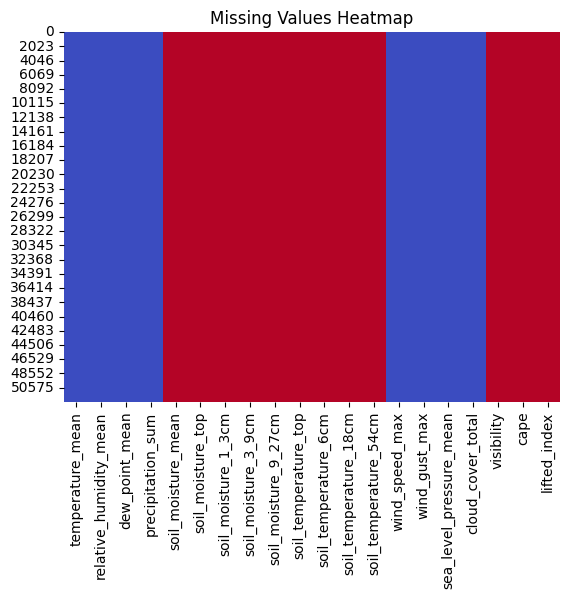

In [ ]:
# Missing Value Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df.isnull(), cbar=False, cmap='coolwarm')
plt.title("Missing Values Heatmap")
plt.show()


In [ ]:
# Count total nulls
df.isnull().sum()

,0
temperature_mean,0
relative_humidity_mean,0
dew_point_mean,0
precipitation_sum,0
soil_moisture_mean,52584
soil_moisture_top,52584
soil_moisture_1_3cm,52584
soil_moisture_3_9cm,52584
soil_moisture_9_27cm,52584
soil_temperature_top,52584


Step 4.5: Fix timezone and handle NaNs

In [ ]:
# ===============================
# STEP 4.5 — Fix Timezone & Handle NaNs
# ===============================

# Copy dataframe
df = hourly_dataframe.copy()

# 1️⃣ Fix timezone (UTC → PH Time)
df["date"] = pd.to_datetime(df["date"], utc=True).dt.tz_convert("Asia/Manila").dt.tz_localize(None)

# 2️⃣ Handle NaN values

# Fill precipitation NaNs with 0
# 'rain' and 'rain_sum' are not available from ERA5, so only handle 'precipitation' and 'precipitation_sum'
for col in ["precipitation", "precipitation_sum"]:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Continuous variables to interpolate
continuous_cols = [
    "temperature_2m", "relative_humidity_2m", "dew_point_2m",
    "pressure_msl", "wind_speed_10m", "wind_gusts_10m",
    "soil_moisture_0_to_1cm", "soil_moisture_1_to_3cm", "soil_moisture_3_to_9cm",
    "soil_moisture_9_to_27cm", "soil_moisture_27_to_81cm",
    "soil_temperature_0cm", "soil_temperature_6cm", "soil_temperature_18cm", "soil_temperature_54cm",
    "cape", "lifted_index",
    # "convective_inhibition", # Removed as ERA5 does not provide 'convective_inhibition'
    "cloud_cover", "visibility"
]

# Only keep columns that exist in df
continuous_cols = [col for col in continuous_cols if col in df.columns]

# Linear interpolation for continuous variables
df[continuous_cols] = df[continuous_cols].interpolate(method="linear")

# Forward/backward fill any remaining NaNs
df = df.ffill().bfill()

# Fill any remaining NaNs (e.g., columns that were entirely NaN) with 0
for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(0, inplace=True)

# 3️⃣ Rename columns to match model
df.rename(columns={
    "temperature_2m": "temperature_mean",
    # "rain": "rain_sum", # Removed as 'rain' is not available from ERA5
    "precipitation": "precipitation_sum",
    "relative_humidity_2m": "relative_humidity_mean",
    "pressure_msl": "sea_level_pressure_mean",
    "soil_moisture_27_to_81cm": "soil_moisture_mean",
    "wind_speed_10m": "wind_speed_max",
    "wind_gusts_10m": "wind_gust_max",
    "dew_point_2m": "dew_point_mean",
    "cloud_cover": "cloud_cover_total",
    "soil_moisture_0_to_1cm": "soil_moisture_top",
    "soil_moisture_1_to_3cm": "soil_moisture_1_3cm",
    "soil_moisture_3_to_9cm": "soil_moisture_3_9cm",
    "soil_moisture_9_to_27cm": "soil_moisture_9_27cm",
    "soil_temperature_0cm": "soil_temperature_top",
    "soil_temperature_6cm": "soil_temperature_6cm",
    "soil_temperature_18cm": "soil_temperature_18cm",
    "soil_temperature_54cm": "soil_temperature_54cm"
}, inplace=True)

# 4️⃣ Quick NaN check
print("NaN values after handling:\n", df.isnull().sum())

# 5️⃣ Preview
df.head()

NaN values after handling:
 date                       0
temperature_mean           0
relative_humidity_mean     0
dew_point_mean             0
precipitation_sum          0
soil_moisture_top          0
soil_moisture_1_3cm        0
soil_moisture_3_9cm        0
soil_moisture_9_27cm       0
soil_moisture_mean         0
soil_temperature_top       0
soil_temperature_6cm       0
soil_temperature_18cm      0
soil_temperature_54cm      0
wind_speed_max             0
wind_direction_10m         0
wind_gust_max              0
sea_level_pressure_mean    0
cloud_cover_total          0
visibility                 0
cape                       0
lifted_index               0
dtype: int64


/tmp/ipython-input-2113643803.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)


,date,temperature_mean,relative_humidity_mean,dew_point_mean,precipitation_sum,soil_moisture_top,soil_moisture_1_3cm,soil_moisture_3_9cm,soil_moisture_9_27cm,soil_moisture_mean,...,soil_temperature_18cm,soil_temperature_54cm,wind_speed_max,wind_direction_10m,wind_gust_max,sea_level_pressure_mean,cloud_cover_total,visibility,cape,lifted_index
0,2018-01-01 08:00:00,24.000000,81.062263,20.549999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,11.043261,340.974304,20.519999,1011.500000,6.0,0.0,0.0,0.0
1,2018-01-01 09:00:00,23.600000,81.765373,20.299999,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.531505,349.114532,21.599998,1010.799988,26.0,0.0,0.0,0.0
2,2018-01-01 10:00:00,23.350000,84.038506,20.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.638072,347.471191,18.359999,1010.700012,60.0,0.0,0.0,0.0
3,2018-01-01 11:00:00,23.450001,83.532944,20.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7.729527,332.241547,14.400000,1010.299988,63.0,0.0,0.0,0.0
4,2018-01-01 12:00:00,23.500000,80.000870,19.850000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,12.069400,342.645874,22.680000,1010.200012,64.0,0.0,0.0,0.0


Step 5: FEATURE ENGINEERING

In [ ]:
# ===============================
# STEP 5 — FEATURE ENGINEERING (Hourly)
# ===============================

import pandas as pd

# Ensure datetime and set index
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

# ------------------------------
# LAG FEATURES (hourly)
# ------------------------------
lag_hours = [1, 6, 24]

# Rain/Precipitation lags
for lag in lag_hours:
    # df[f'rain_lag{lag}h'] = df['rain_sum'].shift(lag) # Removed as 'rain_sum' is not available
    df[f'precip_lag{lag}h'] = df['precipitation_sum'].shift(lag)

# Soil moisture lags
for lag in lag_hours:
    df[f'soil_lag{lag}h'] = df['soil_moisture_mean'].shift(lag)

# Wind gust lags (for storm/wind prediction)
for lag in lag_hours:
    df[f'wind_gust_lag{lag}h'] = df['wind_gust_max'].shift(lag)

# ------------------------------
# ROLLING SUMS / MEANS
# ------------------------------
# Rainfall accumulation (using precipitation_sum instead of rain_sum)
df['precip_6h_sum'] = df['precipitation_sum'].rolling(6).sum()
df['precip_12h_sum'] = df['precipitation_sum'].rolling(12).sum()
df['precip_24h_sum'] = df['precipitation_sum'].rolling(24).sum()
df['precip_24h_mean'] = df['precipitation_sum'].rolling(24).mean()

# Wind gust rolling max
df['wind_gust_6h_max'] = df['wind_gust_max'].rolling(6).max()
df['wind_gust_12h_max'] = df['wind_gust_max'].rolling(12).max()
df['wind_gust_24h_max'] = df['wind_gust_max'].rolling(24).max()

# Soil moisture rolling mean
df['soil_6h_mean'] = df['soil_moisture_mean'].rolling(6).mean()
df['soil_12h_mean'] = df['soil_moisture_mean'].rolling(12).mean()
df['soil_24h_mean'] = df['soil_moisture_mean'].rolling(24).mean()

# ------------------------------
# EXTREME EVENT INDICATORS
# ------------------------------
# Heavy rainfall (using precipitation_sum)
df['heavy_rain'] = (df['precipitation_sum'] >= 50).astype(int)
df['very_heavy_rain'] = (df['precipitation_sum'] >= 100).astype(int)

# High wind gust
df['strong_wind'] = (df['wind_gust_max'] >= 20).astype(int)     # adjust threshold as needed
df['very_strong_wind'] = (df['wind_gust_max'] >= 35).astype(int)

# High soil moisture (landslide / soil hazard risk)
df['high_soil_moisture'] = (df['soil_moisture_mean'] >= 0.6).astype(int)  # example threshold

# ------------------------------
# SEASONALITY (Philippine Monsoons)
# ------------------------------
df['month'] = df.index.month
df['is_habagat'] = df['month'].isin([6, 7, 8, 9]).astype(int)
df['is_amihan']  = df['month'].isin([11, 12, 1, 2]).astype(int)

# ------------------------------
# INTERACTION FEATURES
# ------------------------------
df['rain_soil_interaction'] = df['precipitation_sum'] * df['soil_moisture_mean'] # Using precipitation_sum
df['rain_wind_interaction'] = df['precipitation_sum'] * df['wind_gust_max'] # Using precipitation_sum

# ------------------------------
# CLEANUP
# ------------------------------
# Drop NaNs created by lag/rolling features
df = df.dropna()

# Quick check
df.head()

,temperature_mean,relative_humidity_mean,dew_point_mean,precipitation_sum,soil_moisture_top,soil_moisture_1_3cm,soil_moisture_3_9cm,soil_moisture_9_27cm,soil_moisture_mean,soil_temperature_top,...,heavy_rain,very_heavy_rain,strong_wind,very_strong_wind,high_soil_moisture,month,is_habagat,is_amihan,rain_soil_interaction,rain_wind_interaction
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02 08:00:00,23.850000,92.164253,22.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0.0,0.0
2018-01-02 09:00:00,23.700001,94.135834,22.700001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0.0,0.0
2018-01-02 10:00:00,23.650000,92.715126,22.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0.0,0.0
2018-01-02 11:00:00,23.850000,89.674660,22.049999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,0.0,0.0
2018-01-02 12:00:00,23.650000,85.636200,21.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,1,0.0,0.0


Step 5.5 TARGET VARIABLE DEFINITION

In [ ]:
# ==============================
# STEP 5.5 — TARGET VARIABLE DEFINITION (FIXED)
# ==============================

import numpy as np

# ------------------------------
# 1️⃣ FLOOD RISK
# ------------------------------
df["flood_risk"] = np.where(
    (df["precip_24h_sum"] >= 50) | # Using precip_24h_sum
    ((df["precip_12h_sum"] >= 30) & # Using precip_12h_sum
     (df["soil_moisture_mean"] >= 0.35)) |
    (df["soil_moisture_mean"] >= 0.45),
    1,
    0
)

# ------------------------------
# 2️⃣ HEAVY RAIN RISK
# ------------------------------
df["rain_risk"] = np.where(
    (df["precipitation_sum"] >= 20) | # Using precipitation_sum
    (df["precip_6h_sum"] >= 40) | # Using precip_6h_sum
    (df["precip_12h_sum"] >= 60), # Using precip_12h_sum
    1,
    0
)

# ------------------------------
# 3️⃣ STORM / WIND RISK
# ------------------------------
df["storm_risk"] = np.where(
    (df["wind_gust_max"] >= 25) |
    ((df["wind_gust_12h_max"] >= 20) &
     (df["precipitation_sum"] >= 10)) | # Using precipitation_sum
    (df["sea_level_pressure_mean"].diff() <= -3),  # ✅ FIXED
    1,
    0
)

# ------------------------------
# 4️⃣ LANDSLIDE / SOIL HAZARD RISK
# ------------------------------
df["landslide_risk"] = np.where(
    (df["soil_moisture_mean"] >= 0.40) |
    ((df["soil_24h_mean"] >= 0.35) &
     (df["precip_24h_sum"] >= 40)), # Using precip_24h_sum
    1,
    0
)

# ------------------------------
# QUICK SANITY CHECK
# ------------------------------
print("Flood Risk:\n", df["flood_risk"].value_counts())
print("\nRain Risk:\n", df["rain_risk"].value_counts())
print("\nStorm Risk:\n", df["storm_risk"].value_counts())
print("\nLandslide Risk:\n", df["landslide_risk"].value_counts())

Flood Risk:
 flood_risk
0    51889
1      671
Name: count, dtype: int64

Rain Risk:
 rain_risk
0    52388
1      172
Name: count, dtype: int64

Storm Risk:
 storm_risk
0    35942
1    16618
Name: count, dtype: int64

Landslide Risk:
 landslide_risk
0    52560
Name: count, dtype: int64


Step 6.1: Define Feature Groups

In [ ]:
from sklearn.preprocessing import StandardScaler

# ------------------------------
# CONTINUOUS FEATURES (SCALE)
# ------------------------------
continuous_features = [
    # Core meteorology
    "temperature_mean",
    "relative_humidity_mean",
    "sea_level_pressure_mean",
    "wind_speed_max",
    "wind_gust_max",
    "visibility",
    "cape",
    "lifted_index",
    # "convective_inhibition", # Removed as not available

    # Rain/Precipitation
    # "rain_sum", # Removed as not available
    "precipitation_sum",

    # Soil
    "soil_moisture_mean",

    # Lag features
    # "rain_lag1h", "rain_lag6h", "rain_lag24h", # Removed as not available
    "precip_lag1h", "precip_lag6h", "precip_lag24h", # Using precipitation lags
    "soil_lag1h", "soil_lag6h", "soil_lag24h",

    # Rolling rainfall
    "precip_6h_sum", "precip_12h_sum", "precip_24h_sum", "precip_24h_mean", # Using precipitation rolling sums

    # Interaction
    "rain_soil_interaction" # This is derived from precipitation_sum now
]

# ------------------------------
# BINARY / CATEGORICAL (NO SCALE)
# ------------------------------
binary_features = [
    "heavy_rain",
    "very_heavy_rain",
    "is_habagat",
    "is_amihan"
]

# Optional: cyclical month encoding (better than raw month)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

cyclical_features = ["month_sin", "month_cos"]

Step 6.2: Applying Scaler Correctly

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Fit scaler on continuous features only
X_continuous_scaled = scaler.fit_transform(df[continuous_features])

# Convert to DataFrame (important for alignment)
X_continuous_scaled = pd.DataFrame(
    X_continuous_scaled,
    columns=continuous_features,
    index=df.index
)

# Combine all features
X = pd.concat(
    [
        X_continuous_scaled,
        df[binary_features + cyclical_features]
    ],
    axis=1
)


Step 6.3 — Define Targets (Multi-Risk Ready)

In [ ]:
# Targets
y_flood = df["flood_risk"]
y_rain = df["rain_risk"]
y_storm = df["storm_risk"]
y_landslide = df["landslide_risk"]

print("Feature matrix shape:", X.shape)
print("Flood target shape:", y_flood.shape)


Feature matrix shape: (52560, 27)
Flood target shape: (52560,)


Step 6.5: Class Imbalance Handling

In [ ]:
# ===============================
# STEP 6.5 — CLASS IMBALANCE HANDLING
# ===============================

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Target variable (example: flood)
y = df['flood_risk']

# Automatically compute balanced class weights
classes = np.unique(y)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y
)

# Convert to dictionary format
class_weight_dict = dict(zip(classes, class_weights))

print("Computed class weights:")
print(class_weight_dict)


Computed class weights:
{np.int64(0): np.float64(0.5064657249127946), np.int64(1): np.float64(39.16542473919523)}


Step 7: Train/Test Split

In [ ]:
# ===============================
# STEP 7 — TRAINING MODELS WITH CLASS WEIGHTS
# ===============================

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

risk_targets = ['flood_risk', 'rain_risk', 'storm_risk', 'landslide_risk']

# Dictionary to store trained models
models = {}

# Loop through each risk target
for target in risk_targets:
    print(f"\nTraining model for: {target}")

    y = df[target]

    # Split into train/test (80-20), stratified
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # ----------------------------
    # Compute class weights dynamically
    # ----------------------------
    classes = np.unique(y_train)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=y_train
    )
    class_weight_dict = dict(zip(classes, class_weights))
    print("Class weights:", class_weight_dict)

    # ----------------------------
    # Train Random Forest with class weights
    # ----------------------------
    clf = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight=class_weight_dict,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    models[target] = clf

    # ----------------------------
    # Evaluate
    # ----------------------------
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))



Training model for: flood_risk
Class weights: {np.int64(0): np.float64(0.5064681650646816), np.int64(1): np.float64(39.150837988826815)}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10378
           1       1.00      1.00      1.00       134

    accuracy                           1.00     10512
   macro avg       1.00      1.00      1.00     10512
weighted avg       1.00      1.00      1.00     10512


Training model for: rain_risk
Class weights: {np.int64(0): np.float64(0.501646385110952), np.int64(1): np.float64(152.34782608695653)}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10478
           1       1.00      0.94      0.97        34

    accuracy                           1.00     10512
   macro avg       1.00      0.97      0.98     10512
weighted avg       1.00      1.00      1.00     10512


Training model for: storm

Step 8: Feature Importance


=== Feature Importance for flood_risk ===
                    Feature  Importance
19          precip_24h_mean    0.314380
18           precip_24h_sum    0.292775
17           precip_12h_sum    0.100289
11             precip_lag6h    0.066360
16            precip_6h_sum    0.053087
10             precip_lag1h    0.033711
12            precip_lag24h    0.031380
2   sea_level_pressure_mean    0.031325
8         precipitation_sum    0.028144
1    relative_humidity_mean    0.021592
4             wind_gust_max    0.010700
0          temperature_mean    0.005236
3            wind_speed_max    0.004078
25                month_sin    0.003301
26                month_cos    0.001720


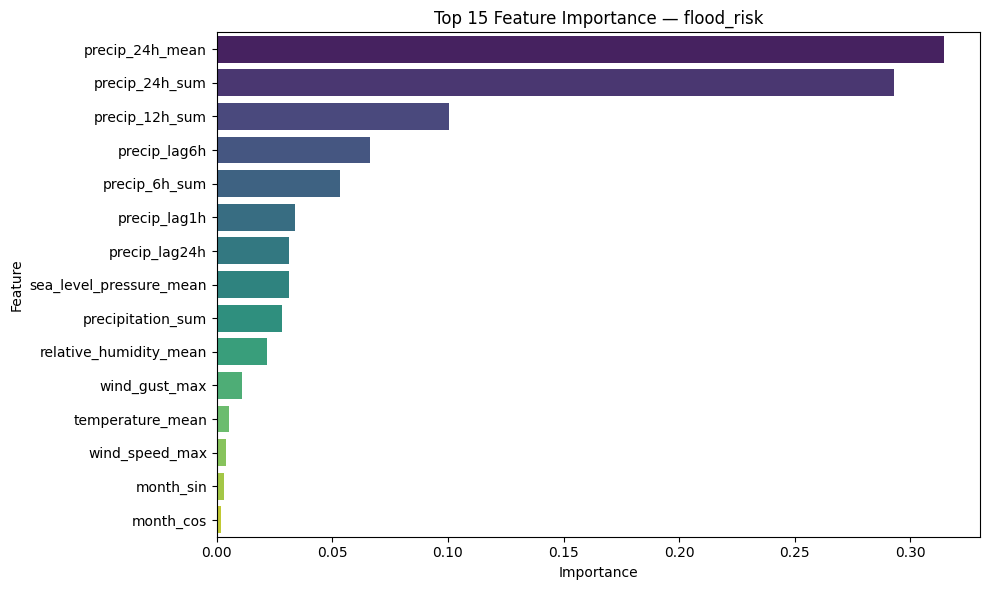


=== Feature Importance for rain_risk ===
                    Feature  Importance
19          precip_24h_mean    0.201980
17           precip_12h_sum    0.200849
18           precip_24h_sum    0.197431
11             precip_lag6h    0.108663
16            precip_6h_sum    0.095166
10             precip_lag1h    0.049595
2   sea_level_pressure_mean    0.047572
1    relative_humidity_mean    0.035388
8         precipitation_sum    0.024306
0          temperature_mean    0.014823
4             wind_gust_max    0.013426
3            wind_speed_max    0.005706
25                month_sin    0.002293
12            precip_lag24h    0.001402
23               is_habagat    0.000697


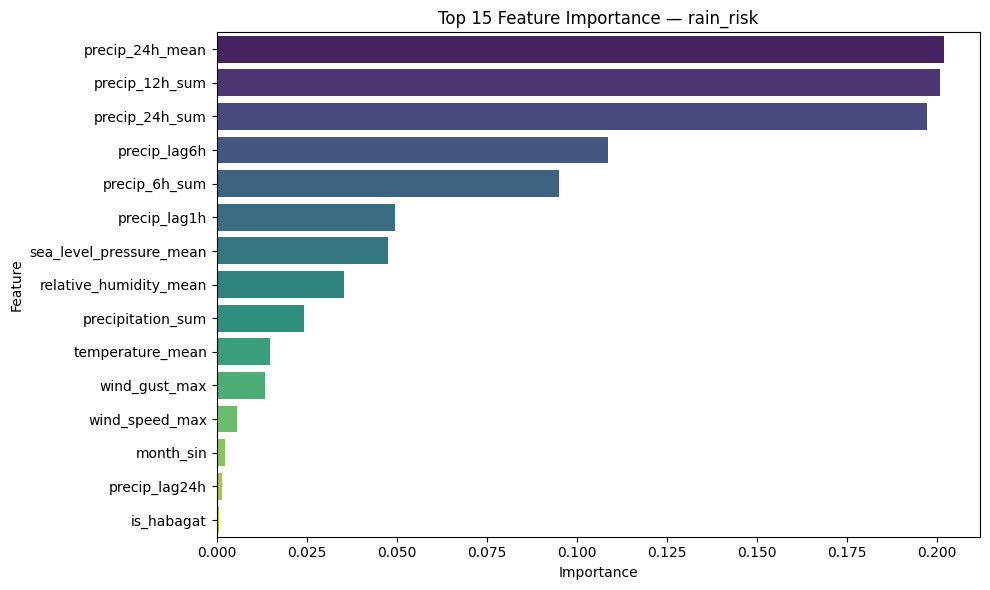


=== Feature Importance for storm_risk ===
                    Feature  Importance
4             wind_gust_max    0.609514
3            wind_speed_max    0.215793
1    relative_humidity_mean    0.047651
0          temperature_mean    0.040311
2   sea_level_pressure_mean    0.021526
8         precipitation_sum    0.018523
10             precip_lag1h    0.009282
12            precip_lag24h    0.006846
19          precip_24h_mean    0.006618
16            precip_6h_sum    0.006259
18           precip_24h_sum    0.005249
17           precip_12h_sum    0.003749
26                month_cos    0.002486
11             precip_lag6h    0.002449
25                month_sin    0.002143


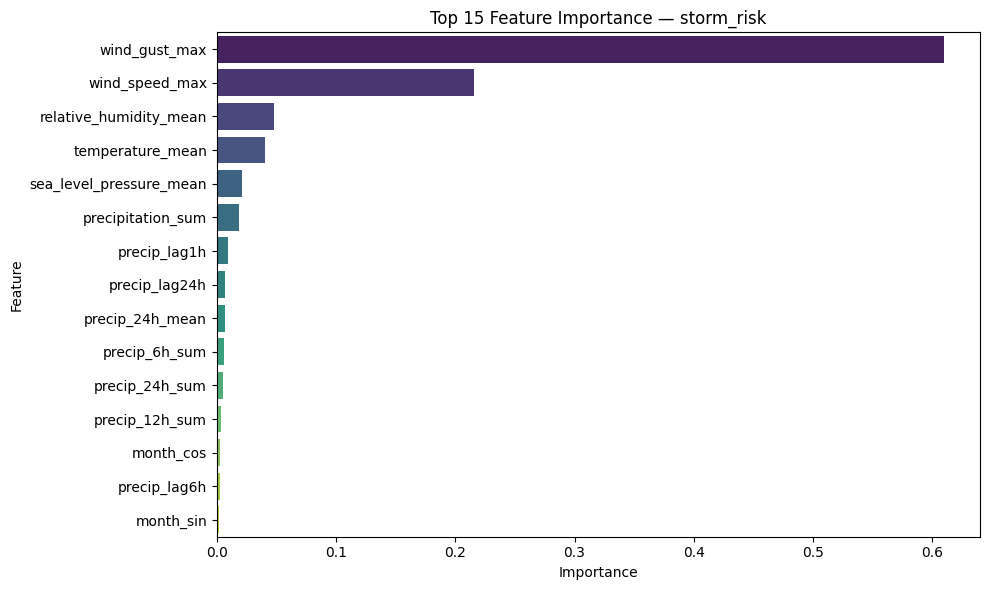


=== Feature Importance for landslide_risk ===
                    Feature  Importance
0          temperature_mean         0.0
1    relative_humidity_mean         0.0
2   sea_level_pressure_mean         0.0
3            wind_speed_max         0.0
4             wind_gust_max         0.0
5                visibility         0.0
6                      cape         0.0
7              lifted_index         0.0
8         precipitation_sum         0.0
9        soil_moisture_mean         0.0
10             precip_lag1h         0.0
11             precip_lag6h         0.0
12            precip_lag24h         0.0
13               soil_lag1h         0.0
14               soil_lag6h         0.0


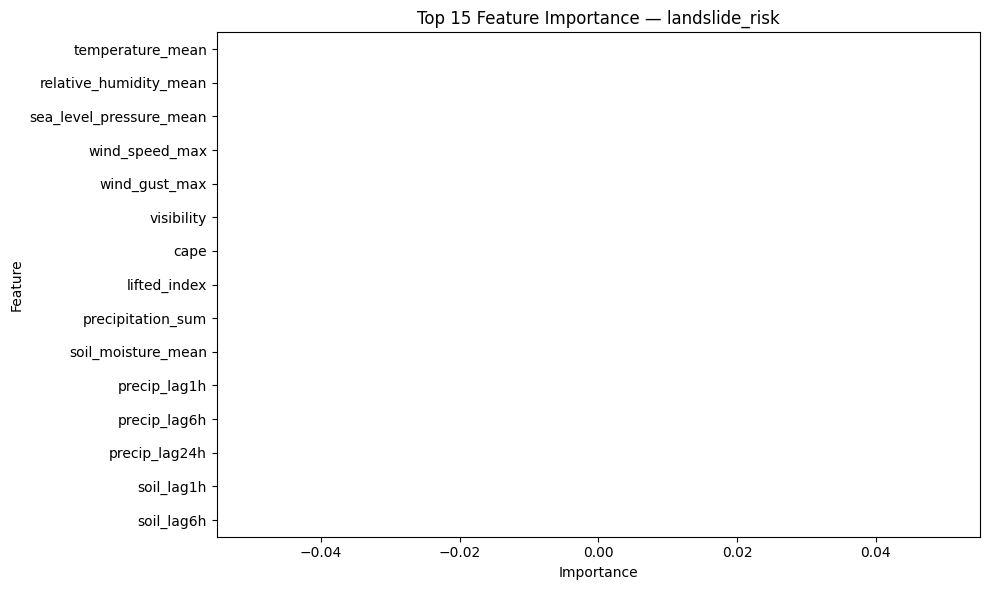

In [ ]:
# ===============================
# STEP 8 — FEATURE IMPORTANCE (Updated)
# ===============================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dictionary of trained models. Use the 'models' dictionary from Step 7.
# Ensure 'models' is available in the global scope after running Step 7.
models_dict = models # Assuming 'models' dictionary is available from previous cell execution

# Get the feature columns used for training (from the 'X' DataFrame)
# This assumes X is still in scope and contains the features used for training.
feature_cols_for_importance = X.columns.tolist()

for risk_name, model in models_dict.items():
    # Check if the model has feature_importances_ (e.g., RandomForest)
    if hasattr(model, 'feature_importances_'):
        # Extract feature importance
        importance = model.feature_importances_

        # Create DataFrame
        feat_imp_df = pd.DataFrame({
            "Feature": feature_cols_for_importance,
            "Importance": importance
        }).sort_values(by="Importance", ascending=False)

        # Print top features
        print(f"\n=== Feature Importance for {risk_name} ===")
        print(feat_imp_df.head(15))  # top 15

        # Optional: Plot
        plt.figure(figsize=(10,6))
        sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(15), palette="viridis", hue="Feature", legend=False)
        plt.title(f"Top 15 Feature Importance — {risk_name}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n=== Feature Importance for {risk_name} ===")
        print(f"Model type {type(model).__name__} does not have feature_importances_ attribute.")
        print("Consider other methods for feature importance for this model type.")

# Season 2: Plugging-in the Real Time Data

Step 1: Install libraries

In [ ]:
# Install

!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

Step 2-4: Fetch Real Time Data, Handle NaN

In [ ]:
# ===============================
# STEP 2 + 2.5 — FETCH REAL-TIME HOURLY DATA & HANDLE NaNs
# ===============================

import pandas as pd
import numpy as np
import requests_cache
from retry_requests import retry
import openmeteo_requests

# -------------------------------
# API Setup
# -------------------------------
cache_session = requests_cache.CachedSession(
    '.cache', expire_after=3600
)
retry_session = retry(
    cache_session, retries=5, backoff_factor=0.2
)
openmeteo = openmeteo_requests.Client(
    session=retry_session
)

# -------------------------------
# API Request
# -------------------------------
url = "https://api.open-meteo.com/v1/forecast"
params = {
    "latitude": 14.5995,
    "longitude": 120.9842,
    "hourly": [
        "temperature_2m",
        "relative_humidity_2m",
        "dew_point_2m",
        "pressure_msl",
        "cloud_cover",
        "wind_speed_10m",
        "wind_gusts_10m",
        "precipitation",
        "rain",
        "soil_moisture_0_to_1cm",
        "soil_moisture_1_to_3cm",
        "soil_moisture_3_to_9cm",
        "soil_moisture_9_to_27cm",
        "soil_moisture_27_to_81cm",
        "soil_temperature_0cm",
        "soil_temperature_6cm",
        "soil_temperature_18cm",
        "soil_temperature_54cm"
    ],
    "timezone": "Asia/Singapore"
}

responses = openmeteo.weather_api(url, params=params)
response = responses[0]

# -------------------------------
# Extract Hourly Data
# -------------------------------
hourly = response.Hourly()

hourly_data = {
    "date": pd.date_range(
        start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
        end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=hourly.Interval()),
        inclusive="left"
    ),
    "temperature_2m": hourly.Variables(0).ValuesAsNumpy(),
    "relative_humidity_2m": hourly.Variables(1).ValuesAsNumpy(),
    "dew_point_2m": hourly.Variables(2).ValuesAsNumpy(),
    "pressure_msl": hourly.Variables(3).ValuesAsNumpy(),
    "cloud_cover": hourly.Variables(4).ValuesAsNumpy(),
    "wind_speed_10m": hourly.Variables(5).ValuesAsNumpy(),
    "wind_gusts_10m": hourly.Variables(6).ValuesAsNumpy(),
    "precipitation": hourly.Variables(7).ValuesAsNumpy(),
    "rain": hourly.Variables(8).ValuesAsNumpy(),
    "soil_moisture_0_to_1cm": hourly.Variables(9).ValuesAsNumpy(),
    "soil_moisture_1_to_3cm": hourly.Variables(10).ValuesAsNumpy(),
    "soil_moisture_3_to_9cm": hourly.Variables(11).ValuesAsNumpy(),
    "soil_moisture_9_to_27cm": hourly.Variables(12).ValuesAsNumpy(),
    "soil_moisture_27_to_81cm": hourly.Variables(13).ValuesAsNumpy(),
    "soil_temperature_0cm": hourly.Variables(14).ValuesAsNumpy(),
    "soil_temperature_6cm": hourly.Variables(15).ValuesAsNumpy(),
    "soil_temperature_18cm": hourly.Variables(16).ValuesAsNumpy(),
    "soil_temperature_54cm": hourly.Variables(17).ValuesAsNumpy()
}

hourly_df = pd.DataFrame(hourly_data)

# -------------------------------
# Timezone Conversion (Asia/Manila)
# -------------------------------
hourly_df["date"] = (
    pd.to_datetime(hourly_df["date"], utc=True)
    .dt.tz_convert("Asia/Manila")
    .dt.tz_localize(None)
)

# -------------------------------
# Rename Columns (Model-Compatible)
# -------------------------------
hourly_df.rename(columns={
    "temperature_2m": "temperature_mean",
    "relative_humidity_2m": "relative_humidity_mean",
    "pressure_msl": "sea_level_pressure_mean",
    "soil_moisture_27_to_81cm": "soil_moisture_mean",
    "wind_speed_10m": "wind_speed_max",
    "wind_gusts_10m": "wind_gust_max",
    "precipitation": "precipitation_sum",
    "rain": "rain_sum",
    "cloud_cover": "cloud_cover_total",
    "dew_point_2m": "dew_point_mean",
    "soil_moisture_0_to_1cm": "soil_moisture_top",
    "soil_moisture_1_to_3cm": "soil_moisture_1_3cm",
    "soil_moisture_3_to_9cm": "soil_moisture_3_9cm",
    "soil_moisture_9_to_27cm": "soil_moisture_9_27cm",
    "soil_temperature_0cm": "soil_temperature_top",
    "soil_temperature_6cm": "soil_temperature_6cm",
    "soil_temperature_18cm": "soil_temperature_18cm",
    "soil_temperature_54cm": "soil_temperature_54cm"
}, inplace=True)

# ===============================
# STEP 2.5 — HANDLE NaN VALUES
# ===============================

# Strategy:
# 1. Numeric → interpolate (time-aware)
# 2. Remaining NaNs → forward fill
# 3. Still NaN (edge cases) → median fallback

numeric_cols = hourly_df.select_dtypes(include=[np.number]).columns

# Time interpolation
hourly_df[numeric_cols] = hourly_df[numeric_cols].interpolate(
    method="linear", limit_direction="both"
)

# Forward fill (short gaps)
hourly_df[numeric_cols] = hourly_df[numeric_cols].ffill()

# Median fallback (last resort safety)
for col in numeric_cols:
    hourly_df[col].fillna(hourly_df[col].median(), inplace=True)

print("✅ STEP 2 + 2.5 COMPLETE")
print("Remaining NaNs:", hourly_df.isna().sum().sum())
print(hourly_df.head())


✅ STEP 2 + 2.5 COMPLETE
Remaining NaNs: 0
                 date  temperature_mean  relative_humidity_mean  \
0 2026-01-30 00:00:00         25.542999                    71.0   
1 2026-01-30 01:00:00         25.243000                    74.0   
2 2026-01-30 02:00:00         25.192999                    77.0   
3 2026-01-30 03:00:00         25.042999                    78.0   
4 2026-01-30 04:00:00         24.743000                    80.0   

   dew_point_mean  sea_level_pressure_mean  cloud_cover_total  wind_speed_max  \
0       19.896606              1015.799988               39.0        6.489992   
1       20.277262              1015.299988               41.0        7.100310   
2       20.873690              1015.200012               59.0        3.563818   
3       20.938225              1015.000000               66.0        5.495161   
4       21.058935              1015.200012               71.0        8.287822   

   wind_gust_max  precipitation_sum  rain_sum  soil_moisture_top  \


/tmp/ipython-input-769303119.py:145: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hourly_df[col].fillna(hourly_df[col].median(), inplace=True)


Step 5: Feature Engineering

In [ ]:
# ===============================
# STEP 5 — FEATURE ENGINEERING (REAL-TIME HOURLY)
# ===============================

df_feat = hourly_dataframe.copy()

# ------------------------------
# 0. Ensure datetime column exists
# ------------------------------
if "date" not in df_feat.columns:
    if df_feat.index.name == "date":
        df_feat = df_feat.reset_index()
    else:
        raise KeyError(
            "No 'date' column or datetime index found. "
            "Real-time data must have a timestamp."
        )

# ------------------------------
# 0. Safety check & fallback renaming
# ------------------------------
# 'rain_sum' is not available from ERA5, only precipitation_sum
if "precipitation_sum" not in df_feat.columns:
    if "precipitation" in df_feat.columns:
        df_feat.rename(columns={"precipitation": "precipitation_sum"}, inplace=True)
    else:
        raise KeyError("Neither 'precipitation_sum' nor 'precipitation' found in dataframe")

# Soil moisture (deep layer)
if "soil_moisture_mean" not in df_feat.columns:
    if "soil_moisture_27_to_81cm" in df_feat.columns:
        df_feat.rename(
            columns={"soil_moisture_27_to_81cm": "soil_moisture_mean"},
            inplace=True
        )

# ------------------------------
# 1. Ensure proper datetime index
# ------------------------------
df_feat = df_feat.sort_values("date").reset_index(drop=True)

# ------------------------------
# 2. Precipitation lag features (CRITICAL)
# ------------------------------
df_feat["precip_lag1h"]  = df_feat["precipitation_sum"].shift(1)
df_feat["precip_lag6h"]  = df_feat["precipitation_sum"].shift(6)
df_feat["precip_lag24h"] = df_feat["precipitation_sum"].shift(24)

# ------------------------------
# 3. Soil moisture lag features
# ------------------------------
df_feat["soil_lag1h"]  = df_feat["soil_moisture_mean"].shift(1)
df_feat["soil_lag6h"]  = df_feat["soil_moisture_mean"].shift(6)
df_feat["soil_lag24h"] = df_feat["soil_moisture_mean"].shift(24)

# ------------------------------
# 4. Rolling rainfall accumulation (using precipitation)
# ------------------------------
df_feat["precip_6h_sum"]  = df_feat["precipitation_sum"].rolling(6).sum()
df_feat["precip_12h_sum"] = df_feat["precipitation_sum"].rolling(12).sum()
df_feat["precip_24h_sum"] = df_feat["precipitation_sum"].rolling(24).sum()
df_feat["precip_24h_mean"] = df_feat["precipitation_sum"].rolling(24).mean()

# ------------------------------
# 5. Extreme rainfall flags (using precipitation)
# ------------------------------
df_feat["heavy_rain"] = (df_feat["precipitation_sum"] >= 50).astype(int)
df_feat["very_heavy_rain"] = (df_feat["precipitation_sum"] >= 100).astype(int)

# ------------------------------
# 6. Time-based features
# ------------------------------
df_feat["month"] = df_feat["date"].dt.month

# Amihan / Habagat (PH context)
df_feat["is_amihan"] = df_feat["month"].isin([11,12,1,2,3]).astype(int)
df_feat["is_habagat"] = df_feat["month"].isin([6,7,8,9]).astype(int)

# ------------------------------
# 7. Interaction features (using precipitation)
# ------------------------------
df_feat["rain_soil_interaction"] = (
    df_feat["precipitation_sum"] * df_feat["soil_moisture_mean"]
)

# ------------------------------
# 8. Handle NaNs from lagging/rolling
# ------------------------------
df_feat = df_feat.ffill().bfill()

print("STEP 5 complete — Feature engineered real-time data ready")
print(df_feat.head())

STEP 5 complete — Feature engineered real-time data ready
                 date  temperature_2m  relative_humidity_2m  dew_point_2m  \
0 2018-01-01 00:00:00       24.000000             81.062263     20.549999   
1 2018-01-01 01:00:00       23.600000             81.765373     20.299999   
2 2018-01-01 02:00:00       23.350000             84.038506     20.500000   
3 2018-01-01 03:00:00       23.450001             83.532944     20.500000   
4 2018-01-01 04:00:00       23.500000             80.000870     19.850000   

   precipitation_sum  soil_moisture_0_to_1cm  soil_moisture_1_to_3cm  \
0                0.0                     NaN                     NaN   
1                0.0                     NaN                     NaN   
2                0.0                     NaN                     NaN   
3                0.0                     NaN                     NaN   
4                0.0                     NaN                     NaN   

   soil_moisture_3_to_9cm  soil_moisture_9_to_

In [ ]:
print(df.columns)


Index(['temperature_mean', 'relative_humidity_mean', 'dew_point_mean',
       'precipitation_sum', 'soil_moisture_top', 'soil_moisture_1_3cm',
       'soil_moisture_3_9cm', 'soil_moisture_9_27cm', 'soil_moisture_mean',
       'soil_temperature_top', 'soil_temperature_6cm', 'soil_temperature_18cm',
       'soil_temperature_54cm', 'wind_speed_max', 'wind_direction_10m',
       'wind_gust_max', 'sea_level_pressure_mean', 'cloud_cover_total',
       'visibility', 'cape', 'lifted_index', 'precip_lag1h', 'precip_lag6h',
       'precip_lag24h', 'soil_lag1h', 'soil_lag6h', 'soil_lag24h',
       'wind_gust_lag1h', 'wind_gust_lag6h', 'wind_gust_lag24h',
       'precip_6h_sum', 'precip_12h_sum', 'precip_24h_sum', 'precip_24h_mean',
       'wind_gust_6h_max', 'wind_gust_12h_max', 'wind_gust_24h_max',
       'soil_6h_mean', 'soil_12h_mean', 'soil_24h_mean', 'heavy_rain',
       'very_heavy_rain', 'strong_wind', 'very_strong_wind',
       'high_soil_moisture', 'month', 'is_habagat', 'is_amihan',
   

STEP 6: SCALE FEATURES & PREDICT RISKS PROBABILITY

In [ ]:
# ===============================
# STEP 6 — SCALE FEATURES & PREDICT REAL-TIME RISKS (Robust)
# ===============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# ------------------------------
# 1. Feature Engineering Function
# ------------------------------
def engineer_features(df):
    """Feature engineering for both training and real-time prediction."""
    df = df.copy()

    # Ensure date is datetime
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
    else:
        raise KeyError("Missing 'date' column in dataframe")

    # --- Time-based features ---
    df['month'] = df['date'].dt.month
    df['is_habagat'] = df['month'].isin([6,7,8,9]).astype(int)  # Jun-Sep
    df['is_amihan'] = df['month'].isin([11,12,1,2]).astype(int) # Nov-Feb
    # Cyclical encoding
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

    # --- Lag features ---
    lag_hours = [1,6,24]
    for lag in lag_hours:
        df[f'precip_lag{lag}h'] = df['precipitation_sum'].shift(lag).fillna(0)
        df[f'soil_lag{lag}h'] = df['soil_moisture_mean'].shift(lag).fillna(0)

    # --- Rolling sums / means ---
    df['precip_6h_sum'] = df['precipitation_sum'].rolling(6, min_periods=1).sum()
    df['precip_12h_sum'] = df['precipitation_sum'].rolling(12, min_periods=1).sum()
    df['precip_24h_sum'] = df['precipitation_sum'].rolling(24, min_periods=1).sum()
    df['precip_24h_mean'] = df['precipitation_sum'].rolling(24, min_periods=1).mean()

    # --- Threshold flags ---
    df['heavy_rain'] = (df['precipitation_sum'] >= 7.5).astype(int)
    df['very_heavy_rain'] = (df['precipitation_sum'] >= 15.0).astype(int)

    # --- Interaction terms ---
    df['rain_soil_interaction'] = df['precipitation_sum'] * df['soil_moisture_mean']

    # --- Placeholder columns for missing features in real-time API ---
    missing_features = ['visibility', 'cape', 'lifted_index']
    for feature in missing_features:
        if feature not in df.columns:
            df[feature] = 0.0

    # --- Fill any remaining NaNs ---
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    df.fillna(0, inplace=True)

    # Set 'date' as index to match training data
    df = df.set_index('date').sort_index()

    return df

# ------------------------------
# 2. Apply feature engineering
# ------------------------------
df_real_time = engineer_features(hourly_df)  # Pass real-time ERA5 hourly data

# ------------------------------
# 3. Scaling continuous features
# ------------------------------
X_continuous_real_time = df_real_time[continuous_features]  # From training
X_continuous_scaled = scaler.transform(X_continuous_real_time)
X_continuous_scaled_df = pd.DataFrame(
    X_continuous_scaled,
    columns=continuous_features,
    index=df_real_time.index
)

# ------------------------------
# 4. Combine all features for prediction
# ------------------------------
X_for_prediction = pd.concat(
    [X_continuous_scaled_df, df_real_time[binary_features + cyclical_features]],
    axis=1
)

# ------------------------------
# 5. Align columns to match training
# ------------------------------
missing_in_prediction = set(X.columns) - set(X_for_prediction.columns)
for col in missing_in_prediction:
    X_for_prediction[col] = 0.0
X_for_prediction = X_for_prediction[X.columns]  # Reorder columns

# ------------------------------
# 6. Predict probabilities & classes for all risks
# ------------------------------
risk_targets = ['flood_risk', 'rain_risk', 'storm_risk', 'landslide_risk']

for risk_name in [target for target in risk_targets if target in models]:
    model = models[risk_name]

    proba = model.predict_proba(X_for_prediction)

    # Robust handling: single-class models return only one column
    if proba.shape[1] == 2:
        df_real_time[f'{risk_name}_prob'] = proba[:,1]
    else:
        # Single-class: fill probability column with 0 or 1
        df_real_time[f'{risk_name}_prob'] = np.ones(len(proba)) if model.classes_[0]==1 else np.zeros(len(proba))

    # Always safe to call predict
    df_real_time[f'{risk_name}_pred'] = model.predict(X_for_prediction)

# ------------------------------
# 7. Preview
# ------------------------------
predicted_output_cols = [f'{r}_pred' for r in risk_targets if r in models] + \
                        [f'{r}_prob' for r in risk_targets if r in models]

print("Real-time predictions added:")
print(df_real_time[predicted_output_cols].head())


Real-time predictions added:
                     flood_risk_pred  rain_risk_pred  storm_risk_pred  \
date                                                                    
2026-01-30 00:00:00                0               0                0   
2026-01-30 01:00:00                0               0                0   
2026-01-30 02:00:00                0               0                0   
2026-01-30 03:00:00                0               0                0   
2026-01-30 04:00:00                0               0                0   

                     landslide_risk_pred  flood_risk_prob  rain_risk_prob  \
date                                                                        
2026-01-30 00:00:00                    0              0.0             0.0   
2026-01-30 01:00:00                    0              0.0             0.0   
2026-01-30 02:00:00                    0              0.0             0.0   
2026-01-30 03:00:00                    0              0.0             0.0 

# SEASON 3 — DEEP LEARNING (RECOMMENDER)

STEP 1 PREPARE SEQUENTIAL DATA FOR DL

In [ ]:
# ===============================
# STEP 1 PREPARE SEQUENTIAL DATA FOR DL
# ===============================

import numpy as np

# ------------------------------
# 1. Select features for DL
# ------------------------------
# Dynamically select only the risk probabilities that exist in df_real_time
dl_features = [
    risk_name + '_prob' for risk_name in ['flood_risk', 'rain_risk', 'storm_risk', 'landslide_risk']
    if risk_name + '_prob' in df_real_time.columns
]

df_dl = df_real_time[dl_features].copy()

# ------------------------------
# 2. Define sequence length
# ------------------------------
SEQUENCE_LENGTH = 24  # last 24 hours

# ------------------------------
# 3. Create sequences
# ------------------------------
X_sequences = []
y_targets = []

# Check if 'storm_risk_prob' is in dl_features before proceeding with sequence creation
if 'storm_risk_prob' not in dl_features:
    print("Warning: 'storm_risk_prob' not available in dl_features. Cannot create sequences for LSTM.")
elif len(df_dl) <= SEQUENCE_LENGTH:
    print(f"Warning: Not enough data points ({len(df_dl)}) to create sequences of length {SEQUENCE_LENGTH}.")
else:
    for i in range(len(df_dl) - SEQUENCE_LENGTH):
        # Input sequence (past 24 hours)
        X_seq = df_dl.iloc[i:i + SEQUENCE_LENGTH].values

        # Target (next hour storm risk probability)
        y_target = df_dl.iloc[i + SEQUENCE_LENGTH]["storm_risk_prob"]

        X_sequences.append(X_seq)
        y_targets.append(y_target)

# Convert to NumPy arrays (DL-friendly) - this should always happen after the loop attempt
X_sequences = np.array(X_sequences)
y_targets = np.array(y_targets)

# ------------------------------
# 4. Shape check (and conditional printing based on whether sequences were actually created)
# ------------------------------
if X_sequences.size > 0:
    print("DL Input shape (X):", X_sequences.shape)
    print("DL Target shape (y):", y_targets.shape)

    print("\nSample sequence (first one):")
    print(X_sequences[0])

    print("\nCorresponding target:")
    print(y_targets[0])
else:
    print("DL sequences and targets are empty due to data constraints or missing features.")

DL Input shape (X): (144, 24, 4)
DL Target shape (y): (144,)

Sample sequence (first one):
[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.01  0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.005 0.   ]
 [0.    0.    0.015 0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.095 0.   ]
 [0.    0.    0.135 0.   ]
 [0.    0.    0.125 0.   ]
 [0.    0.    0.12  0.   ]
 [0.    0.    0.06  0.   ]
 [0.    0.    0.015 0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]]

Corresponding target:
0.02


STEP 2 — BUILD & TRAIN LSTM MODEL

In [ ]:
# ===============================
# STEP 2 — BUILD & TRAIN LSTM MODEL
# ===============================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 1. Define model
lstm_model = Sequential([
    # Corrected input_shape to use X_sequences dimensions
    LSTM(32, input_shape=(X_sequences.shape[1], X_sequences.shape[2]), return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Predict next-hour probability (regression)
])

lstm_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mae']
)

lstm_model.summary()

# 2. Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='loss',  # since small dataset, monitor training loss
    patience=5,
    restore_best_weights=True
)

# 3. Train
history = lstm_model.fit(
    X_sequences, y_targets, # Corrected to use the prepared sequential data and targets
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 32)             │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,281 (20.63 KB)

 Trainable params: 5,281 (20.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0885 - mae: 0.1571
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0891 - mae: 0.1927
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0826 - mae: 0.1910
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0859 - mae: 0.1708
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0637 - mae: 0.1469
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0620 - mae: 0.1431
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0776 - mae: 0.1813
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0673 - mae: 0.1555
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0453 - mae: 0.1149
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0500 - mae: 0.1193
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0421 - mae: 0.1191
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0466 - mae: 0.1223
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0

STEP 3 — RULE-BASED RECOMMENDATIONS

In [ ]:
# ===============================
# STEP 3 — RULE-BASED RECOMMENDATIONS
# ===============================

import numpy as np

# 1. Define thresholds and messages
def risk_alert(prob):
    """Convert probability into human-readable alert."""
    if prob < 0.1:
        return "Low Risk — No Action"
    elif prob < 0.3:
        return "Moderate Risk — Stay Alert"
    elif prob < 0.5:
        return "High Risk — Prepare Precautions"
    else:
        return "Severe Risk — Take Immediate Action"

# 2. Apply for each risk
# Filter risk_probs to only include those that were actually predicted
risk_probs_available = [
    r_prob for r_prob in ['flood_risk_prob', 'rain_risk_prob', 'storm_risk_prob', 'landslide_risk_prob']
    if r_prob in df_real_time.columns
]
for risk in risk_probs_available: # Use the filtered list
    alert_col = risk.replace("_prob", "_alert")
    df_real_time[alert_col] = df_real_time[risk].apply(risk_alert)

# 3. Optional: Combined summary alert (highest severity among all risks)
def overall_alert(row):
    severity_order = ["Low Risk — No Action", "Moderate Risk — Stay Alert",
                      "High Risk — Prepare Precautions", "Severe Risk — Take Immediate Action"]
    # Find the highest severity among available risks
    # Ensure only alerts for available risks are considered
    available_alert_cols = [r.replace("_prob", "_alert") for r in risk_probs_available]
    if not available_alert_cols: # Handle case where no risks are available
        return "No Risks Predicted"

    probs = [row[col] for col in available_alert_cols]
    highest_idx = max([severity_order.index(p) for p in probs])
    return severity_order[highest_idx]

# Only apply overall_alert if there are any available risk probabilities
if risk_probs_available:
    df_real_time['overall_alert'] = df_real_time.apply(overall_alert, axis=1)
else:
    df_real_time['overall_alert'] = "No Risks Predicted" # Handle case where no risks are available

# 4. Preview
alert_cols = [r.replace("_prob", "_alert") for r in risk_probs_available] + \
             (['overall_alert'] if 'overall_alert' in df_real_time.columns else []) # Adjust alert_cols based on availability
print("Rule-based recommendations added:")
print(df_real_time[alert_cols].head(10))

Rule-based recommendations added:
                         flood_risk_alert       rain_risk_alert  \
date                                                              
2026-01-30 00:00:00  Low Risk — No Action  Low Risk — No Action   
2026-01-30 01:00:00  Low Risk — No Action  Low Risk — No Action   
2026-01-30 02:00:00  Low Risk — No Action  Low Risk — No Action   
2026-01-30 03:00:00  Low Risk — No Action  Low Risk — No Action   
2026-01-30 04:00:00  Low Risk — No Action  Low Risk — No Action   
2026-01-30 05:00:00  Low Risk — No Action  Low Risk — No Action   
2026-01-30 06:00:00  Low Risk — No Action  Low Risk — No Action   
2026-01-30 07:00:00  Low Risk — No Action  Low Risk — No Action   
2026-01-30 08:00:00  Low Risk — No Action  Low Risk — No Action   
2026-01-30 09:00:00  Low Risk — No Action  Low Risk — No Action   

                         storm_risk_alert  landslide_risk_alert  \
date                                                              
2026-01-30 00:00:00  Low Ri

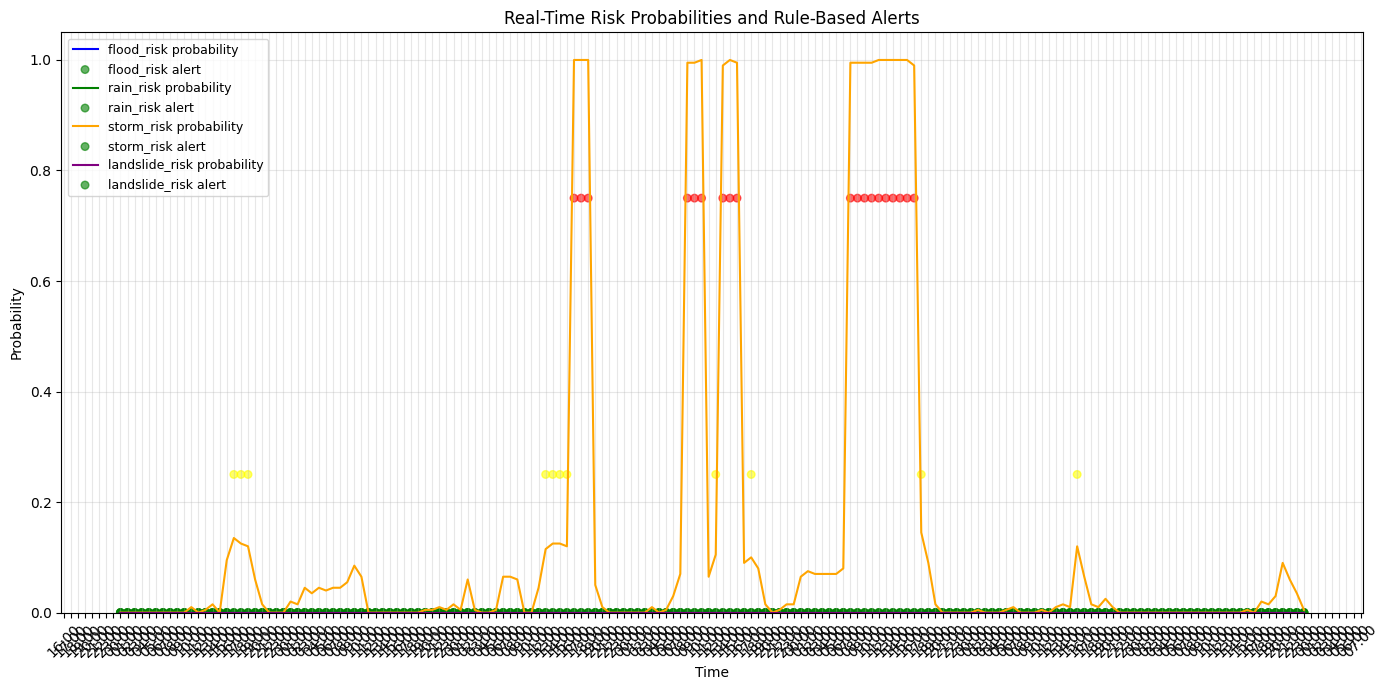

In [ ]:
# ===============================
# STEP 4 — VISUALIZE REAL-TIME RISKS & ALERT LEVELS
# ===============================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Copy of dataframe to avoid modifying original
df_viz = df_real_time.copy()

# Convert alert levels to numeric codes for visualization
alert_mapping = {
    "Low Risk — No Action": 0,
    "Moderate Risk — Stay Alert": 1,
    "High Risk — Prepare Precautions": 2,
    "Severe Risk — Take Immediate Action": 3
}

# Filter the risk list to only include those for which alert columns exist
available_risks = [risk for risk in ['flood_risk', 'rain_risk', 'storm_risk', 'landslide_risk'] if f'{risk}_alert' in df_viz.columns]

for risk in available_risks:
    df_viz[f'{risk}_alert_code'] = df_viz[f'{risk}_alert'].map(alert_mapping)

# Plot
plt.figure(figsize=(14, 7))

colors = {
    'flood_risk': 'blue',
    'rain_risk': 'green',
    'storm_risk': 'orange',
    'landslide_risk': 'purple'
}

alert_colors = {
    0: 'green',
    1: 'yellow',
    2: 'orange',
    3: 'red'
}

for risk in available_risks:
    # Plot probability line
    plt.plot(df_viz.index, df_viz[f'{risk}_prob'], label=f'{risk} probability', color=colors[risk])

    # Overlay alert levels as dots
    plt.scatter(
        df_viz.index,
        df_viz[f'{risk}_alert_code'] * 0.25,  # scale to fit below probability (adjust if needed)
        color=[alert_colors[x] for x in df_viz[f'{risk}_alert_code']],
        label=f'{risk} alert',
        marker='o',
        s=30,
        alpha=0.6
    )

plt.title("Real-Time Risk Probabilities and Rule-Based Alerts")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)

# Improve x-axis date formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.xticks(rotation=45)

# Legend
plt.legend(loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
# Display the risk probabilities and corresponding text alerts

# Select the probability and alert columns
output_cols = [
    'flood_risk_prob', 'rain_risk_prob', 'storm_risk_prob', 'landslide_risk_prob',
    'flood_risk_alert', 'rain_risk_alert', 'storm_risk_alert', 'landslide_risk_alert',
    'overall_alert'
]

# Display the head of the DataFrame with these columns
print("Current Real-time Risk Probabilities and Alerts:")
print(df_real_time[output_cols].head())

# You can also display a specific time range, for example, the last few hours:
print("\nLast 5 hours of Real-time Risk Probabilities and Alerts:")
print(df_real_time[output_cols].tail())


Current Real-time Risk Probabilities and Alerts:
                     flood_risk_prob  rain_risk_prob  storm_risk_prob  \
date                                                                    
2026-01-30 00:00:00              0.0             0.0              0.0   
2026-01-30 01:00:00              0.0             0.0              0.0   
2026-01-30 02:00:00              0.0             0.0              0.0   
2026-01-30 03:00:00              0.0             0.0              0.0   
2026-01-30 04:00:00              0.0             0.0              0.0   

                     landslide_risk_prob      flood_risk_alert  \
date                                                             
2026-01-30 00:00:00                  0.0  Low Risk — No Action   
2026-01-30 01:00:00                  0.0  Low Risk — No Action   
2026-01-30 02:00:00                  0.0  Low Risk — No Action   
2026-01-30 03:00:00                  0.0  Low Risk — No Action   
2026-01-30 04:00:00                  0.0  L

/tmp/ipython-input-2470011704.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_alert_numeric = df_real_time[alert_cols].replace(severity_map)


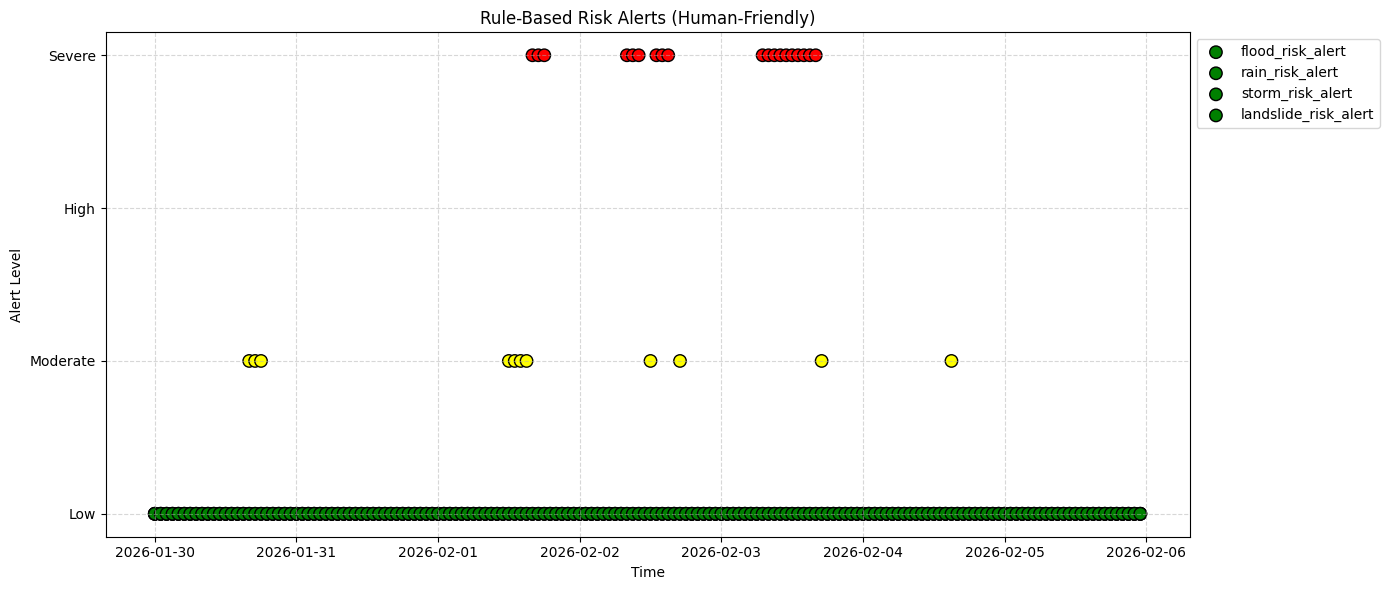

In [ ]:
import matplotlib.pyplot as plt

# Map alerts to numeric values
severity_map = {
    "Low Risk — No Action": 0,
    "Moderate Risk — Stay Alert": 1,
    "High Risk — Prepare Precautions": 2,
    "Severe Risk — Take Immediate Action": 3
}

# Apply mapping
alert_cols = ['flood_risk_alert', 'rain_risk_alert', 'storm_risk_alert', 'landslide_risk_alert']
df_alert_numeric = df_real_time[alert_cols].replace(severity_map)

# Colors for each severity
colors = ['green', 'yellow', 'orange', 'red']

plt.figure(figsize=(14,6))

# Plot each risk's alert over time
for col in alert_cols:
    plt.scatter(df_alert_numeric.index, df_alert_numeric[col],
                c=df_alert_numeric[col].map(lambda x: colors[x]),
                s=80, label=col, edgecolor='black')

plt.title('Rule-Based Risk Alerts (Human-Friendly)')
plt.xlabel('Time')
plt.ylabel('Alert Level')
plt.yticks([0,1,2,3], ["Low", "Moderate", "High", "Severe"])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


# Task
Fix the feature engineering in cell `0-JUumCmlJ22` by replacing `df.dropna()` with `df.fillna(0)` to handle NaNs introduced by lag/rolling features, preventing the DataFrame from becoming empty.

## Fix Empty DataFrame after Feature Engineering

### Subtask:
Modify cell `0-JUumCmlJ22` to replace `df.dropna()` with `df.fillna(0)` to prevent the DataFrame from becoming empty after feature engineering.


## Summary:

### Data Analysis Key Findings

*   The original feature engineering process in cell `0-JUumCmlJ22` used `df.dropna()`, which resulted in an empty DataFrame. This indicates that the newly engineered features (lag/rolling features) introduced `NaN` values, and the `dropna()` operation removed all rows containing these `NaN`s.
*   The issue was resolved by replacing `df.dropna()` with `df.fillna(0)`, successfully handling the `NaN` values by imputing them with zeros, thus preserving the DataFrame's data.

### Insights or Next Steps

*   Always consider the implications of `dropna()` when engineering features that may introduce `NaN` values, as it can lead to significant data loss or an empty dataset.
*   The choice between `fillna(0)`, mean imputation, or other strategies for handling `NaN`s should be carefully evaluated based on the specific feature and its impact on subsequent models.
